In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # get more colormaps
plt.style.use("bioAI.mplstyle")
import torch
import scipy
import tqdm

import sys
sys.path.append('../')
from methods import Hexagon, HexagonalGCs
from plotting_functions import set_size, project_cmap, minimal_ticks, scatter3d
from models import RobustSimilitude

In [3]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
#cmap = project_cmap()

In [4]:
dtype=torch.float32
models = []
ncells_to_include = [3,5,7,100]
for ncells in ncells_to_include:
    ci_model = RobustSimilitude(ncells=ncells,dtype=dtype,rectify=False,
                                dropout=False,lr=1e-3,p_magnitude=0,r_magnitude=1e-1) 
    robust_ci_model = RobustSimilitude(ncells=ncells,dtype=dtype,rectify=False,
                                       dropout=False,lr=1e-3,p_magnitude=1e-1,r_magnitude=1e-1) 
    models.append(ci_model)
    models.append(robust_ci_model)

for model in models:
    model.set_phases(torch.normal(torch.zeros((model.ncells,2))+0.2,0.01))

In [5]:
def train_model(model):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    Gs = []
    phases_history = [model.phases.clone().detach().numpy()]
    for epoch in tqdm.trange(4000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        G = np.mean(model.metric_tensor(model.jacobian(rs)).detach().numpy(),axis=0)
        loss_history.append(loss)
        phases_history.append(model.phases.clone().detach().numpy())
        Gs.append(G)
    Gs = np.array(Gs)
    return loss_history, Gs, phases_history

In [6]:
loss_histories, Gss, phases_histories = [],[],[]
for model in models:
    loss_history, Gs, phases_history = train_model(model)
    loss_histories.append(loss_history)
    Gss.append(Gs)
    phases_histories.append(phases_history)
loss_histories = np.array(loss_histories)
Gss = np.array(Gss)

100%|██████████████████████████████████████| 4000/4000 [00:13<00:00, 286.48it/s]


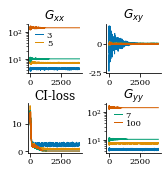

In [7]:
figsize=set_size(fraction=(1/2,1/2),mode='square')
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=figsize)
axs[0,0].semilogy(Gss[::2,:,0,0].T)
axs[0,0].set_title('$G_{xx}$')
axs[0,0].legend(ncells_to_include[:2])#,labelspacing=0,handlelength=1,handletextpad=0.4)
axs[0,1].plot(Gss[::-2,:,1,0].T)#,alpha=.7) # reverse order to plot s.t noisy is plotted first
axs[0,1].set_title('$G_{xy}$')
axs[1,0].plot(loss_histories[::2].T)
axs[1,0].set_title('CI-loss')
artists = axs[1,1].semilogy(Gss[::2,:,1,1].T)
axs[1,1].legend(artists[2:],ncells_to_include[2:])#,labelspacing=0)
axs[1,1].set_title('$G_{yy}$')
plt.subplots_adjust(wspace=0.45, hspace=0.6)

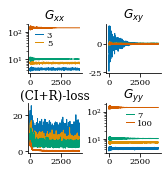

In [8]:
figsize=set_size(fraction=(1/2,1/2),mode='square')
fig,axs = plt.subplots(ncols=2,nrows=2,figsize=figsize)
axs[0,0].semilogy(Gss[1::2,:,0,0].T)
axs[0,0].set_title('$G_{xx}$')
axs[0,0].legend(ncells_to_include[:2])#,labelspacing=0,handlelength=1,handletextpad=0.4)
axs[0,1].plot(Gss[-1::-2,:,1,0].T)#,alpha=.7) # reverse order to plot s.t noisy is plotted first
axs[0,1].set_title('$G_{xy}$')
axs[1,0].plot(loss_histories[1::2].T)
axs[1,0].set_title('(CI+R)-loss')
artists = axs[1,1].semilogy(Gss[1::2,:,1,1].T)
axs[1,1].legend(artists[2:],ncells_to_include[2:])#,labelspacing=0)
axs[1,1].set_title('$G_{yy}$')
plt.subplots_adjust(wspace=0.45, hspace=0.6)

In [78]:
def plot_phases_history(ax,phases_history,center,model,color):
    step=50
    N=len(phases_history)
    # wrap (only relevant) phases history
    phases_history[::step] = [model.unit_cell.wrap(phases_history[i]) for i in range(0,N,step)]
    phases_history += center
    alphas = np.linspace(0.05,0.1,N//step+1)
    [ax.scatter(*phases_history[i].T, s=.5, c='grey',alpha=alphas[i//step]) 
     for i in range(0,N,step)]
    ax.scatter(*phases_history[-1].T, c='red')
    #ax.scatter(*phases_history[0].T,c='blue')
    model.unit_cell.plot(fig,ax,center=center,color=color)

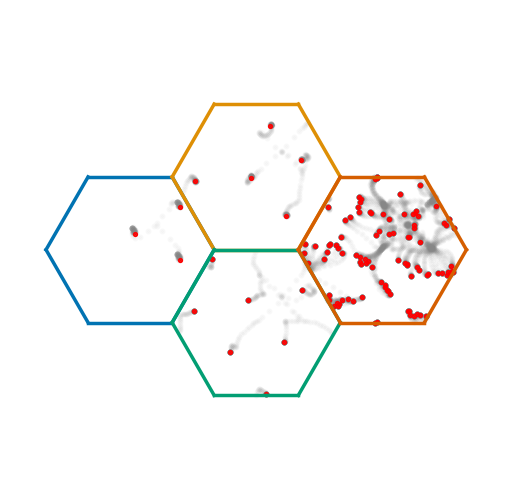

In [79]:
figsize=set_size(fraction=(1/2,1/2),mode='square')
fig,ax = plt.subplots(figsize=figsize,dpi=250)
ax.axis('off')
ax.axis('equal')
sc = model.unit_cell.center # start center
centers = [sc, sc + 2*model.unit_cell.basis[1], 
           sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]]
#for (phases_history,model,center) in zip(phases_histories[::2],models[::2],centers):
for i in range(len(centers)):
    plot_phases_history(ax,phases_histories[i*2],centers[i],models[i*2],color_cycler[i])

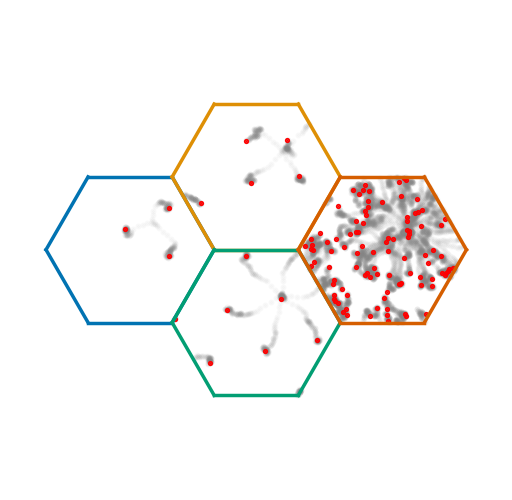

In [80]:
figsize=set_size(fraction=(1/2,1/2),mode='square')
fig,ax = plt.subplots(figsize=figsize,dpi=250)
ax.axis('off')
ax.axis('equal')
sc = model.unit_cell.center # start center
centers = [sc, sc + 2*model.unit_cell.basis[1], 
           sc + 2*model.unit_cell.basis[0], sc + 3*model.unit_cell.hpoints[0]]
#for (phases_history,model,center) in zip(phases_histories[::2],models[::2],centers):
for i in range(len(centers)):
    plot_phases_history(ax,phases_histories[i*2+1],centers[i],models[i*2+1],color_cycler[i])

# INCLUDE A METRIC PERTURBING THE PHASE-SOLUTIONS AND SHOW HOW ROBUSTNESS SCALES WITH NUMBER OF CELLS!

In [25]:
def robustness(model,nsamples_space=2**8,nsamples_statistics=100,**kwargs):
    phases_cpy = model.phases.detach().clone()
    Gs = []
    for i in range(nsamples_statistics):
        dp, _ = model.jitter(len(phases_cpy),**kwargs)
        model.set_phases(phases_cpy + dp)
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        G = np.mean(model.metric_tensor(model.jacobian(rs)).detach().numpy(),axis=0)
        Gs.append(G)
    model.set_phases(phases_cpy)
    return np.array(Gs)

In [28]:
Gs = robustness(model,2**8,100)

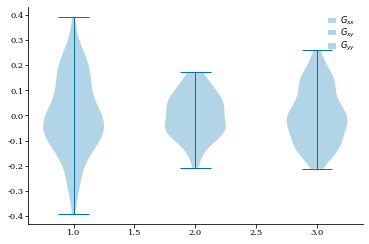

In [60]:
flat_Gs = Gs.reshape(-1,4)[:,(0,1,3)]
flat_Gs -= np.mean(flat_Gs,axis=0,keepdims=True)
violin_plots = plt.violinplot(flat_Gs)
plt.legend(["$G_{xx}$", "$G_{xy}$", "$G_{yy}$"])
#for i,vp in enumerate(violin_plots['bodies']):
#    vp.set_color(color_cycler[i])

In [12]:
# Robustness:
# 1. Wrt. #cells
# 2. Wrt. phase-solutions